In [4]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

- **EAII dataset preparation**

In [5]:
eaii_datset_path = "/home/rdadmin/Documents/Datasets/Coffee-Datasets/eaii_coffee_arabica/segmentation"
os.path.exists(eaii_datset_path)

True

In [6]:
dataset_df = pd.read_csv(os.path.join(eaii_datset_path,"dataset.csv"))
dataset_df.info()
train_df, test_df = train_test_split(dataset_df, train_size=0.8, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   images_names  887 non-null    object
 1   mask_names    887 non-null    object
dtypes: object(2)
memory usage: 14.0+ KB


- Visualize sample data

- Prepare a pytorch dataset

In [8]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF

In [9]:
from typing import Tuple
import random

class CoffeeArabicaDataset(Dataset):
    def __init__(self,df:pd.DataFrame,dataset_path:str,target_size:Tuple = (256,256),train:bool = True) -> None:
        super().__init__()
        self.df = df
        self.dataset_path = dataset_path
        self.train = train
        self.target_size = target_size

    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self, index) -> torch.Tensor:
        # get image and mask file paths
        image_filename = self.df.iloc[index,0]
        mask_filename = self.df.iloc[index,1]
        # read image and masks
        image = cv2.imread(os.path.join(self.dataset_path,image_filename))
        mask = cv2.imread(os.path.join(self.dataset_path,mask_filename))
        # Convert image to rgb
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # convert mask to gray and threshold
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
        _,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
        # Convert image and mask to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        # resize image and mask to the target size
        image  = TF.resize(image,self.target_size)
        mask = TF.resize(mask,self.target_size)
        # add the same random rotation to the image and mask
        if self.train:
            # random rotate
            if random.random() < 0.5:
                angle = random.randint(-20,20)

                image = TF.rotate(image,angle)
                mask =TF.rotate(mask,angle)
                
        return image,mask


- Load Elunet model and weights

In [10]:
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.elunet.elunet import ELUnet 


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elunet_model = ELUnet(3,1,16)


In [12]:
def get_model():
    model = elunet_model.to(device)
    model.load_state_dict(torch.load("./elunet_symptom_lara_leaf_2023-03-24.pth",map_location = device))
    count = 0
    for child in model.children():
        if count > 15:
            for param in child.parameters():
                param.requires_grad = False
        count +=1
    return model

- Cross validation

In [13]:
# Define the dice loss function
# define dice coefficient and dice loss function
def calc_dice_loss(preds:torch.Tensor,targets:torch.Tensor):
    def dice_coefficient(preds:torch.Tensor,targets:torch.Tensor):
        smooth = 1.0
        assert preds.size() == targets.size()
        
        iflat = preds.contiguous().view(-1)
        tflat = targets.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    return 1.0 - dice_coefficient(preds,targets)

In [14]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
# ++++++++++++++++++++++++++++++++++++++++
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 50
# ++++++++++++++++++++++++++++++++++++++++

CURRENT_VAL_LOSS = 0
CURRENT_EPOCH = 0

def early_stopping(val_loss,epoch,patience=10,min_delta=0.01):
        """ Helper method for model training early stopping """
        
        global CURRENT_VAL_LOSS
        global CURRENT_EPOCH

        if val_loss < CURRENT_VAL_LOSS and CURRENT_VAL_LOSS - val_loss >= min_delta:
            # Val loss improved -> save model
            print(f"[Info] Val loss improved from {CURRENT_VAL_LOSS} to {val_loss}")
            #save_model(model)
            CURRENT_VAL_LOSS = val_loss
            CURRENT_EPOCH = epoch
            return False
        if val_loss >= CURRENT_VAL_LOSS and epoch - CURRENT_EPOCH >= patience:
            ## Stop training
            return True
        return False

@torch.no_grad()
def evaluate(model,val_loader):
    progress_bar = tqdm(val_loader,total=len(val_loader))

    val_loss = []
    for i,data in enumerate(progress_bar):
        image,mask = data
        image = image.to(device)
        mask = mask.to(device)
        # get predicition
        mask_pred = model(image)

        loss = calc_dice_loss(mask_pred,mask)

        val_loss.append(loss.item())
        progress_bar.set_description(f"Evaluating")
        progress_bar.set_postfix(eval_loss = np.mean(val_loss),eval_dice = 1 - np.mean(val_loss))
        progress_bar.update()
        
    return np.mean(val_loss)
    
def train(model,train_loader,val_loader):
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    
    model.train()
    for epoch in range(EPOCHS):
        epoch_loss = []
        progress_bar = tqdm(train_loader,total=len(train_loader))
        for i,data in enumerate(progress_bar):
            image,mask = data
            image = image.to(device)
            mask = mask.to(device)
            # get predicition
            mask_pred = model(image)

            loss = calc_dice_loss(mask_pred,mask)
            # empty gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            progress_bar.set_description(f"Epoch {epoch+1}/{EPOCHS}")
            progress_bar.set_postfix(loss = np.mean(epoch_loss),dice = 1 - np.mean(epoch_loss))
            progress_bar.update()
        # Evaluate
        eval_loss = evaluate(model,val_loader)

        if early_stopping(eval_loss,epoch):
            print(f"[INFO] Early Stopping")
            print(f"Stopped!!")
            break



In [15]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

def evaluate_on_test_data():
    # load model
    model = get_model()
    # load the weights
    model.load_state_dict(torch.load("../coffee_arabica_weights/arabica_symptom_2023-03-28.pth",map_location=device))

    # Define dataset
    test_dataset = CoffeeArabicaDataset(test_df,eaii_datset_path,train=False)

    # Define the data loaders for this fold
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    # evaluate model
    fold_loss = evaluate(model,test_loader)
    
    del model
    torch.cuda.empty_cache()
    



In [53]:
# Cross validation scores for each fole
import json
from tabulate import tabulate
from prettytable import PrettyTable

#table = []
table = PrettyTable()
table.field_names = ["Fold", "Mean Loss", "Mean Dice"]

with open("crossval_result.json","r") as f:
    cross_val_scores = json.load(f)


for k,v in cross_val_scores.items():
    i = 0
    for fold_score in v:
        for fold,scores in fold_score.items():
            #table.append([f"Fold {i + 1}",scores["loss"],scores["mDice"]])

            table.add_row([f"Fold {i + 1}",scores["loss"],scores["mDice"]])
            i +=1

#headers = ["Fold", "Loss" "Dice"]
#print(tabulate(table, headers=headers))
print(table)

+--------+---------------------+--------------------+
|  Fold  |      Mean Loss      |     Mean Dice      |
+--------+---------------------+--------------------+
| Fold 1 | 0.18960888187090555 | 0.8103911181290945 |
| Fold 2 | 0.17512811223665872 | 0.8248718877633413 |
| Fold 3 | 0.17356090744336447 | 0.8264390925566355 |
| Fold 4 | 0.18308231234550476 | 0.8169176876544952 |
| Fold 5 | 0.18241779009501138 | 0.8175822099049886 |
+--------+---------------------+--------------------+


In [16]:
evaluate_on_test_data()

Evaluating: 100%|██████████| 6/6 [01:19<00:00, 13.32s/it, eval_dice=0.826, eval_loss=0.174]


In [55]:
import random
# plot sample predictions
@torch.no_grad()
def plot_results():
    # load model
    model = get_model()
    # load the weights
    model.load_state_dict(torch.load("../coffee_arabica_weights/arabica_symptom_2023-03-28.pth",map_location=device))

    # Define dataset
    test_dataset = CoffeeArabicaDataset(test_df,eaii_datset_path,train=False)

    for i in range(15):
        image,mask = test_dataset[random.randint(0,len(test_dataset)-1)]
        image = image.to(device).unsqueeze(0)
        mask = mask.to(device).unsqueeze(0)

        # get mask predicition
        mask_pred = model(image)
        dice_score = 1 - calc_dice_loss(mask_pred,mask)

        plt.figure(figsize=(10,15))
        plt.subplot(1,3,1)
        plt.imshow(image.squeeze(0).permute(1,2,0).cpu().numpy())
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,2)
        plt.imshow(mask.squeeze(0).permute(1,2,0).cpu().numpy(),cmap="gray")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,3)
        plt.imshow(mask_pred.squeeze(0).permute(1,2,0).cpu().numpy(),cmap="gray")
        plt.title(f"dice = {dice_score:2f}")
        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()
    del model
    torch.cuda.empty_cache() 
     

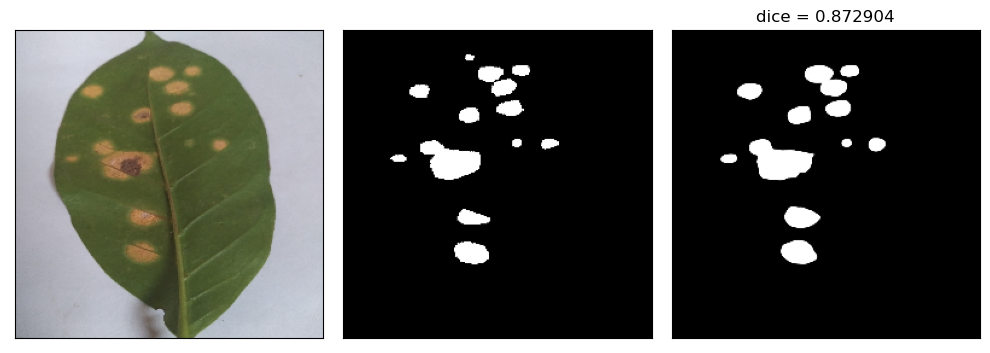

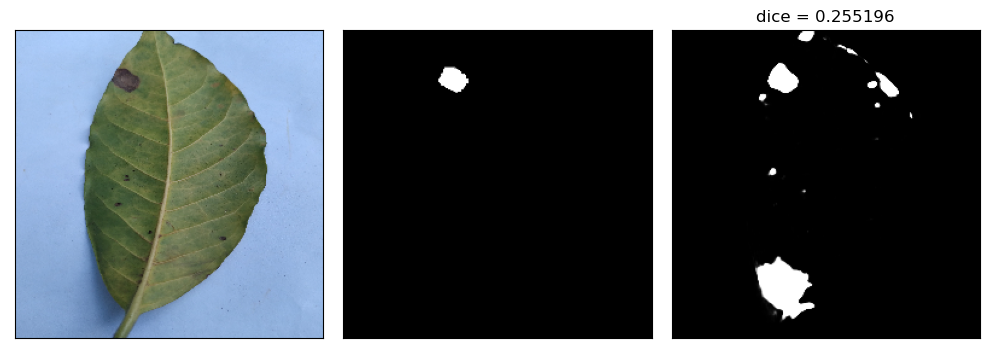

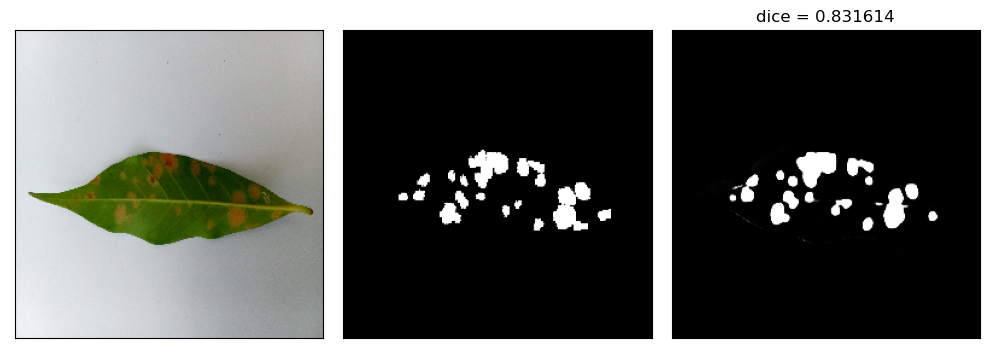

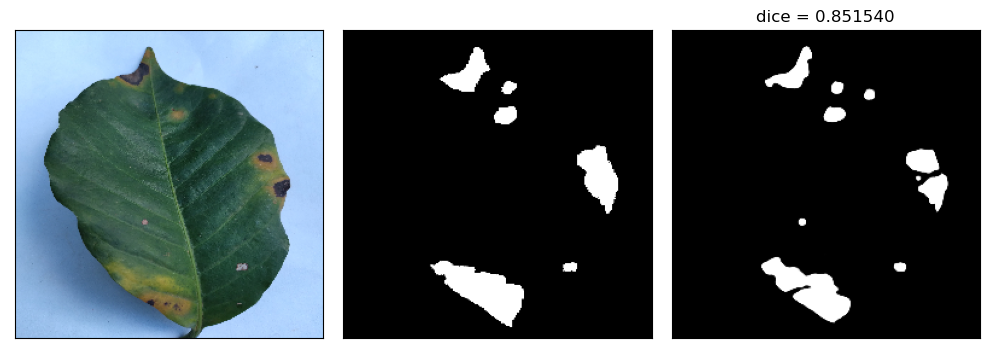

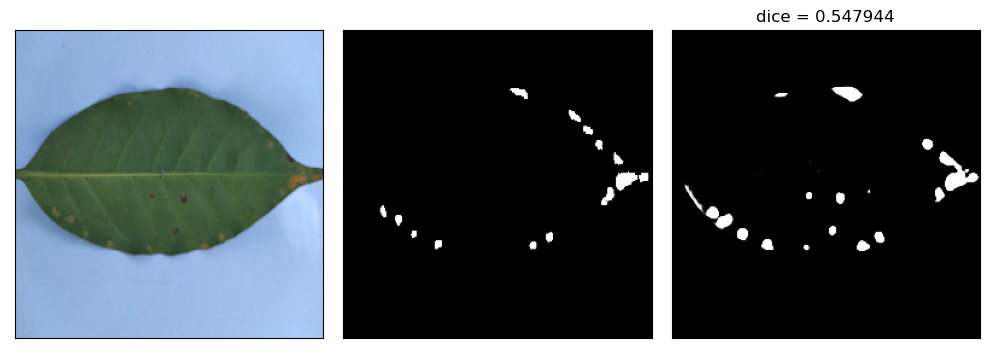

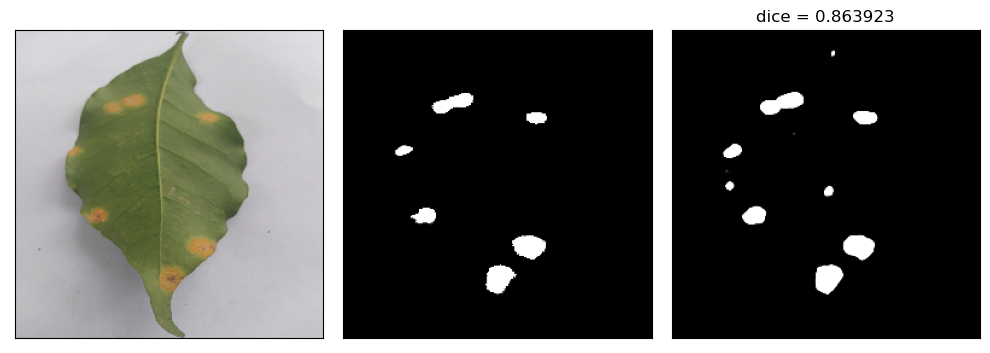

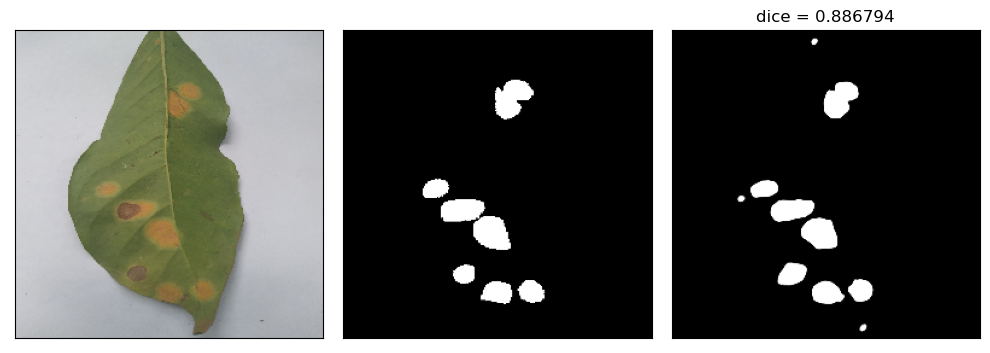

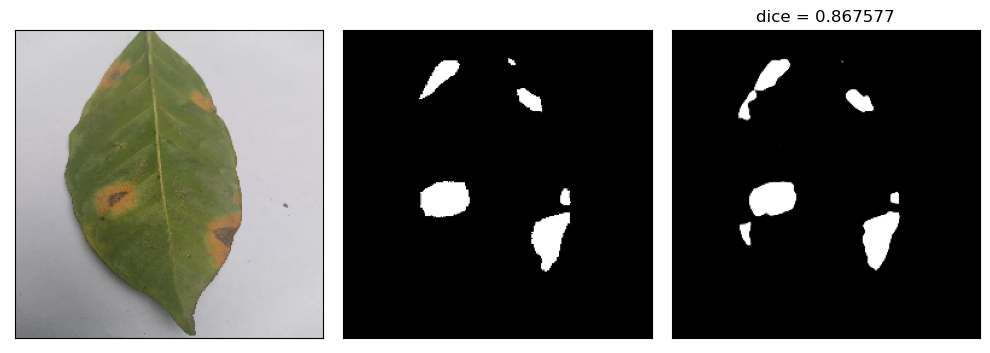

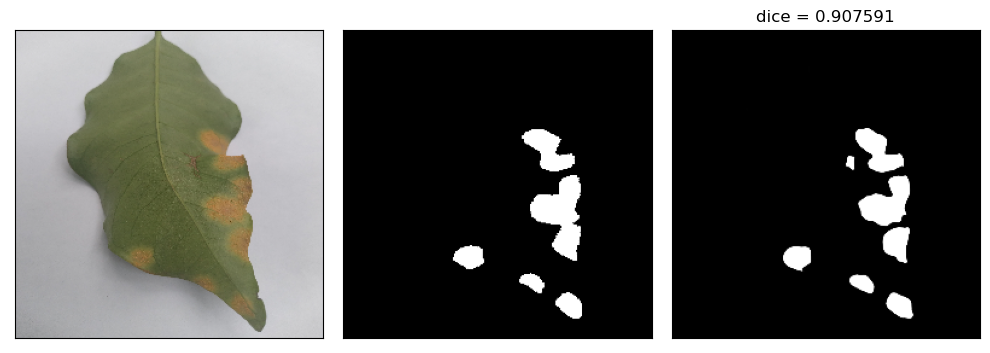

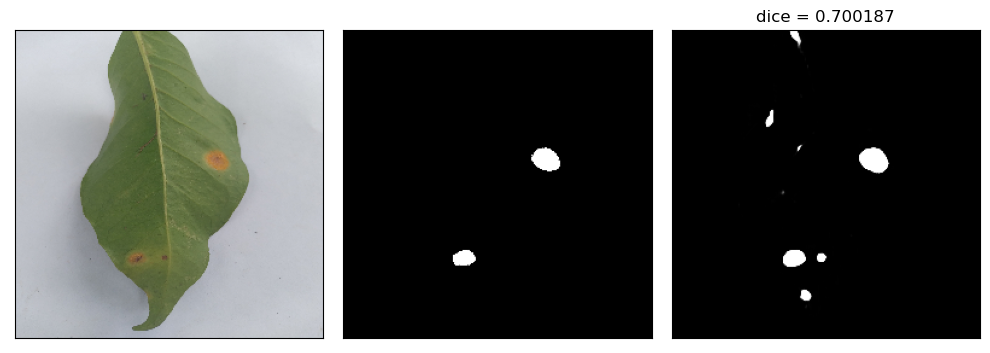

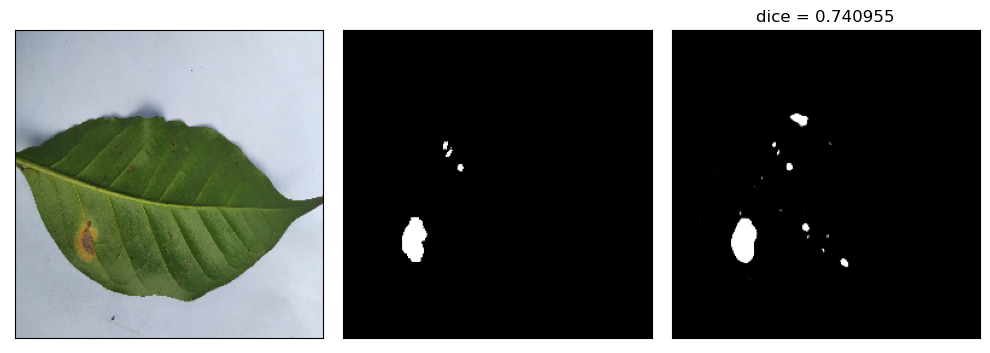

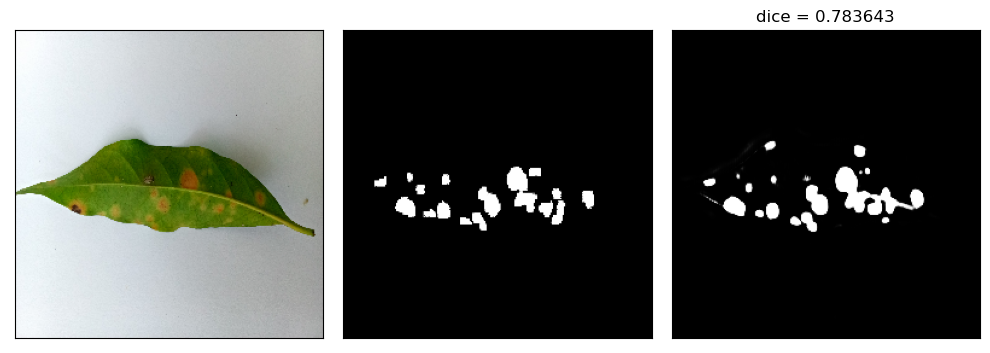

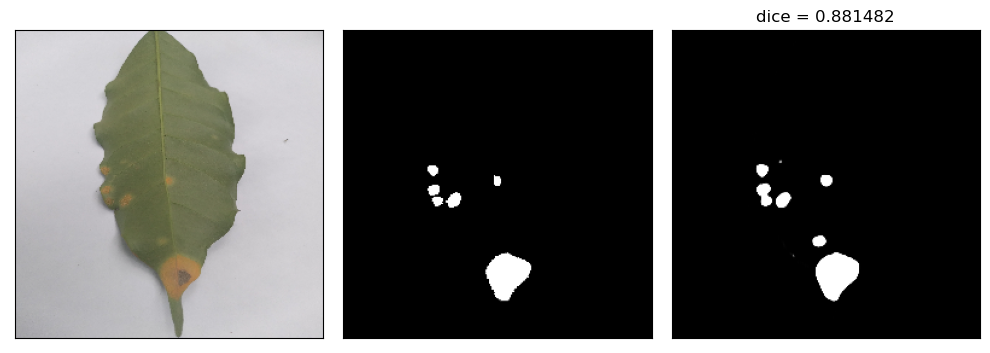

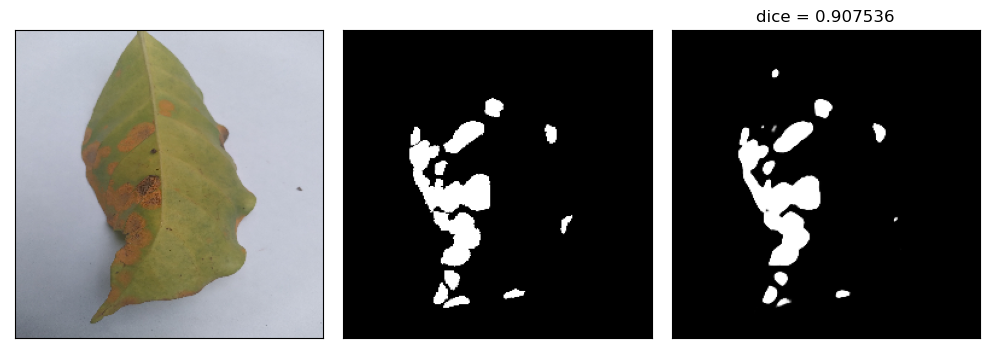

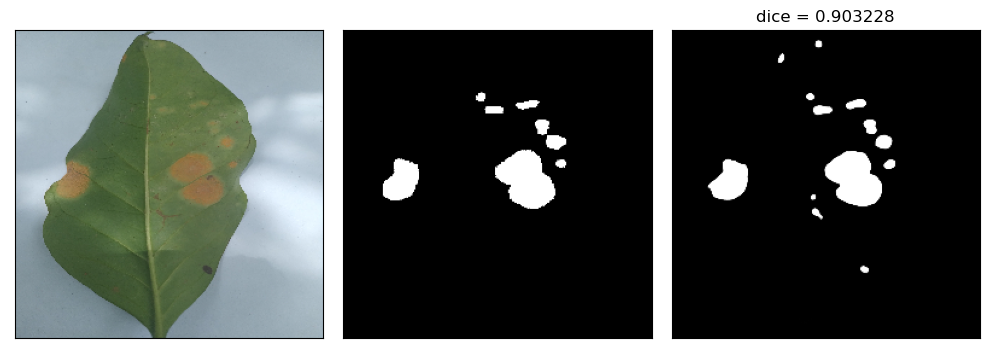

In [56]:
plot_results()

## Quantize and export 

In [54]:
dummy_input = torch.randn(1,3,256,256)

In [59]:
model = get_model()
    # load the weights
model.load_state_dict(torch.load("../coffee_arabica_weights/arabica_symptom_2023-03-28.pth",map_location=torch.device("cpu")))
model = model.to(torch.device("cpu"))


In [60]:
unet_torchscript = torch.jit.trace(model, dummy_input)

In [61]:
#Then optimize the TorchScript formatted model for mobile and save it:
from torch.utils.mobile_optimizer import optimize_for_mobile
torchscript_unet_optimized = optimize_for_mobile(unet_torchscript)
torch.jit.save(torchscript_unet_optimized, "symptom_unet_quantized.pt")